Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - accuracy: 0.9091 - loss: 0.2971 - val_accuracy: 0.9848 - val_loss: 0.0469
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.9865 - loss: 0.0438 - val_accuracy: 0.9885 - val_loss: 0.0337
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9910 - loss: 0.0280 - val_accuracy: 0.9902 - val_loss: 0.0287
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.9942 - loss: 0.0181 - val_accuracy: 0.9900 - val_loss: 0.0301
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.9956 - loss: 0.0136 - val_accuracy: 0.9929 - val_loss: 0.0240
Epoch 1/5
Training acc: 0.9290
Validation acc: 0.9736
Epoch 2/5
Training acc: 0.9783
Validation acc: 0.9819
Epoch 3/5
Training acc: 0.9852
Validation acc: 0.9854
Epoch 4/5
Training acc: 0.9880
Validation acc: 0.9869
Epoch 5/5
Training acc: 0.9893
Validation acc: 0.9870


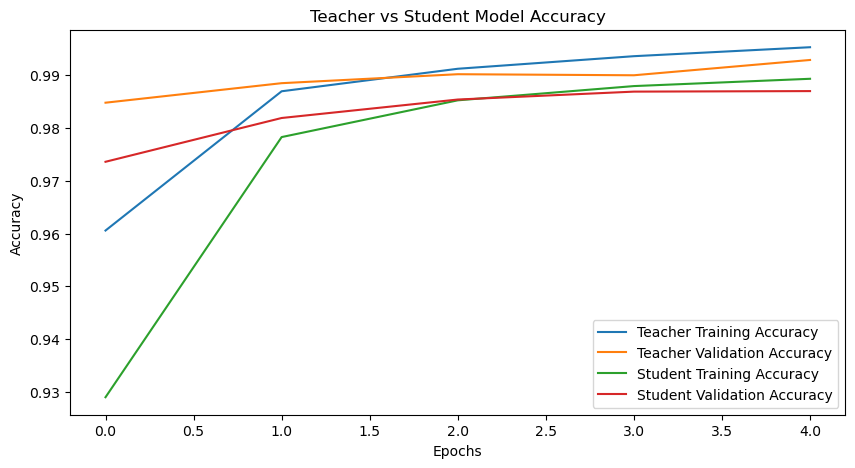

In [9]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize and reshape data
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Define the teacher model
teacher_model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])

# Compile and train the teacher model
teacher_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

history_teacher = teacher_model.fit(x_train, y_train, epochs=5, batch_size=32,
                                    validation_data=(x_test, y_test))

# Define the student model
student_model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(16, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10)
])

# Function for training the student model using knowledge distillation
def train_student_model(student_model, x_train, y_train, teacher_model, x_test, y_test, temperature=10, epochs=5, batch_size=32):
    # Loss function for knowledge distillation
    loss_fn = keras.losses.KLDivergence()

    # Optimizer
    optimizer = keras.optimizers.Adam()

    # Metrics
    train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

    history = {"accuracy": [], "val_accuracy": []}

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Shuffle training data
        indices = np.arange(len(x_train))
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        for step in range(0, len(x_train), batch_size):
            x_batch_train = x_train[step:step + batch_size]
            y_batch_train = y_train[step:step + batch_size]

            with tf.GradientTape() as tape:
                # Forward pass of the teacher model
                teacher_logits = teacher_model(x_batch_train, training=False)
                teacher_probs = tf.nn.softmax(teacher_logits / temperature)

                # Forward pass of the student model
                student_logits = student_model(x_batch_train, training=True)
                student_probs = tf.nn.softmax(student_logits / temperature)

                # Compute the loss
                loss = loss_fn(teacher_probs, student_probs)

            # Compute gradients and update the student model
            grads = tape.gradient(loss, student_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, student_model.trainable_weights))

            # Update training metric
            train_acc_metric.update_state(y_batch_train, student_logits)

        train_acc = train_acc_metric.result()
        print(f"Training acc: {float(train_acc):.4f}")
        history["accuracy"].append(float(train_acc))
        train_acc_metric.reset_state()

        for step in range(0, len(x_test), batch_size):
            x_batch_val = x_test[step:step + batch_size]
            y_batch_val = y_test[step:step + batch_size]

            val_logits = student_model(x_batch_val, training=False)
            val_acc_metric.update_state(y_batch_val, val_logits)

        val_acc = val_acc_metric.result()
        print(f"Validation acc: {float(val_acc):.4f}")
        history["val_accuracy"].append(float(val_acc))
        val_acc_metric.reset_state()

    return student_model, history


# Compile the student model before training
student_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Train the student model using knowledge distillation
student_model, history_student = train_student_model(
    student_model, x_train, y_train, teacher_model, x_test, y_test, temperature=10, epochs=5, batch_size=32
)

# Plotting the results
plt.figure(figsize=(10, 5))

# Teacher model accuracy
plt.plot(history_teacher.history['accuracy'], label='Teacher Training Accuracy')
plt.plot(history_teacher.history['val_accuracy'], label='Teacher Validation Accuracy')

# Student model accuracy
plt.plot(history_student['accuracy'], label='Student Training Accuracy')
plt.plot(history_student['val_accuracy'], label='Student Validation Accuracy')

plt.title('Teacher vs Student Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
